In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [3]:
genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/genotype/data/processed_burden/all_gene_burden.csv.gz"
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
combo_gene_file = "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/british/train_cohort.csv"

In [4]:
genotype_df = pd.read_csv(genotype_file)
phenotype_df = pd.read_csv(phenotype_file)
combo_gene_df = pd.read_csv(combo_gene_file)

In [5]:
phenotype_df.sample_names = phenotype_df.sample_names.astype(str)

In [6]:
combo_gene_df["combo_len"] = combo_gene_df.uniq_items.apply(lambda x: len(x.split("|")))

In [7]:
combo_gene_df[["Gene1", "Gene2", "Gene3"]] = combo_gene_df.uniq_items.str.split("|", expand=True)

In [8]:
def get_gene_samples(row, gene_col, genotype_df):
    if type(row[gene_col])!=str:
        if pd.isnull(row[gene_col]):
            return ""
    gene = row[gene_col].replace("Input_", "")
    all_gene_samples = set(genotype_df.loc[genotype_df.gene==gene, "samples"].values[0].split(","))
    all_combo_samples = set(row.combo_samples.split("|"))
    all_single_gene_samples = all_gene_samples.difference(all_combo_samples)
    return "|".join(all_single_gene_samples)

In [9]:
combo_gene_df["Gene1_samples"] = combo_gene_df.apply(get_gene_samples, args=("Gene1", genotype_df), axis=1)
combo_gene_df["Gene2_samples"] = combo_gene_df.apply(get_gene_samples, args=("Gene2", genotype_df), axis=1)
combo_gene_df["Gene3_samples"] = combo_gene_df.apply(get_gene_samples, args=("Gene3", genotype_df), axis=1)

In [10]:
def get_combo_bmi_info(combo_df, ncombo):
    combo_samples = set("|".join(combo_df.combo_samples.values).split("|"))
    gene_samples = [set("|".join(combo_df[f"Gene{i}_samples"].values).split("|")) for i in range(1, ncombo+1)]
    all_samples = set(phenotype_df.sample_names.values)
    non_gene_samples = all_samples.difference(gene_samples[0].union(gene_samples[1]).union(combo_samples))
    gene1_only_samples = gene_samples[0].difference(gene_samples[1])
    gene2_only_samples = gene_samples[1].difference(gene_samples[0])
    return non_gene_samples, gene1_only_samples, gene2_only_samples, combo_samples

In [11]:
non_gene_samples, gene1_samples, gene2_samples, combo_samples = get_combo_bmi_info(combo_gene_df.loc[combo_gene_df.combo_len==2], 2)

In [12]:
def get_bmi(phenotype_df, samples):
    return phenotype_df.loc[phenotype_df.sample_names.isin(samples), "bmi"].values

In [13]:
all_bmi_info = [get_bmi(phenotype_df, s) for s in [non_gene_samples, gene1_samples, gene2_samples, combo_samples]]

In [55]:
plot_df = pd.DataFrame({
    "Gene A": ["No" for i in range(len(all_bmi_info[0]))] + ["Yes" for i in range(len(all_bmi_info[1]))] + ["No" for i in range(len(all_bmi_info[2]))] + ["Yes" for i in range(len(all_bmi_info[3]))],
    "Gene B": ["No" for i in range(len(all_bmi_info[0]))] + ["No" for i in range(len(all_bmi_info[1]))] + ["Yes" for i in range(len(all_bmi_info[2]))] + ["Yes" for i in range(len(all_bmi_info[3]))],
    "BMI": np.concatenate(all_bmi_info)
})

/tmp/ipykernel_78838/341575667.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), fontsize=18)
/tmp/ipykernel_78838/341575667.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(axes.get_yticklabels(), fontsize=18)


[None, None]

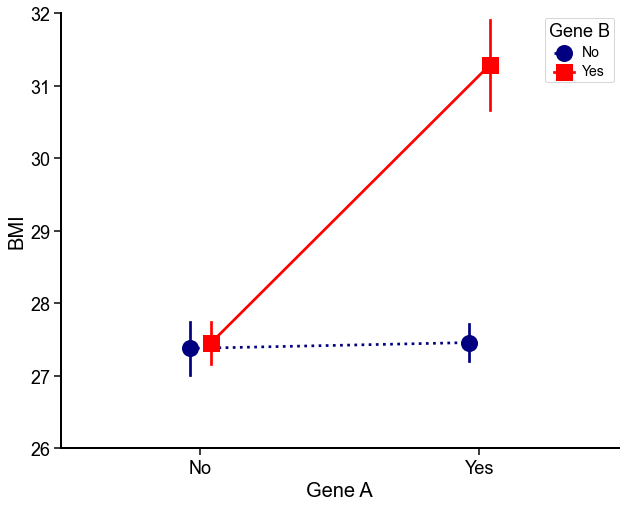

In [70]:
fig, axes = plt.subplots(figsize=(10,8))

sns.pointplot(
    data=plot_df,
    x="Gene A", y="BMI", hue="Gene B",
    markers=["o", "s"], linestyles=[":", "-"], errorbar=("se", 10),
    palette=["navy", "red"], markersize=15,
    dodge=0.075,
    ax=axes
)

axes.set_ylim(26, 32, auto=False)

axes.set_xticklabels(axes.get_xticklabels(), fontsize=18)
axes.set_yticklabels(axes.get_yticklabels(), fontsize=18)

axes.set_xlabel("Gene A", fontsize=20)
axes.set_ylabel("BMI", fontsize=20)

# Remove Spines
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)


plt.setp(axes.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(axes.get_legend().get_title(), fontsize='18') # for legend title

In [69]:
save_pdf("../data/additive_test/british/figures/interaction_plot.pdf", fig)